In [1]:
import tensorflow as tf
import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs

np.random.seed(1234)
tf.set_random_seed(1234)
%matplotlib inline

## Formulation

- Pressure Equation
$$\nabla\cdot[K(x)\cdot\frac{k_{rw}}{\mu_w}(\gamma S_o^n+S_w^n)\nabla P]=-(Q_o+Q_w)$$
- Saturation Equation
$$\phi\frac{\partial S_w}{\partial t} - \nabla\cdot[K(x)\cdot\frac{k_w}{\mu_w} S_w^n\nabla P] = Q_w$$

where

two-phase: $S_w+S_o=1$

relative permeability: $K_{r\sigma} = K_{\sigma}S_{\sigma}^n$,  $\sigma = o,w$

ratio of rel perm $K_{ro} = \alpha K_{rw}$

ratio of viscosity $\mu_o = \beta \mu_w$

ratio $\gamma = \frac{\alpha}{\beta}$

net source term $Q_\sigma = q_\sigma/\rho_\sigma$


Absorb $k_w/\mu_w$ term into $K(x)$ and we have

$$\nabla\cdot[K(x)(\gamma (1-S_w)^n+S_w^n)\nabla P]=-(Q_o+Q_w)$$

and 

$$\phi\frac{\partial S_w}{\partial t} - \nabla\cdot[K(x)S_w^n\nabla P] = Q_w$$


For 2D case, set

Boundary condition (rate)
- close boundary
$\partial_x P = 0$ at left and right boundaries
$\partial_y P = 0$ at top and right boundaries

Injection at $(0,0)$

Production at $(\pm0.75,\pm0.75)$


Initial condition 
- constant pressure
$P = c$ for all $-1\le x \le 1$
- saturation (all oil)
$S_w = constant$ for all $-1\le x,y \le 1$

Known rates: $Q_{prod}$ and $Q_{inj}$

$Q_w = Q_{inj} + Q_{prod}\times F_w$, $F_w = \frac{u_w}{u_w+u_i}=\frac{s_w^n}{\gamma s_(1-s_w)^n+s_w^n}$
$Q_o = Q_{prod}\times (1-F_w)$

$Q_o+Q_w = Q_{inj}+Q_{prod}$


Let
$$v_x = -\partial_x P$$

and

$$v_y = -\partial_y P$$

The equations we need to solve are converted to


$$\partial_x[K(\gamma (1-S_w)^n+S_w^n)v_x] + \partial_y[K(\gamma (1-S_w)^n+S_w^n)v_y]=Q_o+Q_w$$

and 

$$\phi\frac{\partial S_w}{\partial t} + \partial_x[KS_w^nv_x] + \partial_y[KS_w^nv_y] = Q_w$$

A third constraint comes from the fact that $(v_x,v_y)$ is a conservative field (as the gradient of $P$), so that

$$\partial_y v_x - \partial_x v_y = 0$$


In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, XYT_S, S, XYT_VX, VX, XYT_VY, VY, XYT_f, layers, lb, ub, gamma, phi, K, relpermn):
        #XYT_initial, U_initial: where to enforce initial condition. X_initial is a 1D array (location), U_initial is 2D array
        #XYT_boundary, U_boundary: where to enforece boundary condition. X_boundary is a 2D array (location and time), U_boundary is 2D array
        #XYT_f: where to enforce physics equations

        #u is a 1 by 3 vector storing vx, vy and saturation
        
        self.lb = lb
        self.ub = ub
    
        self.gamma, self.phi, self.K, self.relpermn = gamma, phi, K, relpermn
        
        self.x_s = XYT_S[:,0:1]
        self.y_s = XYT_S[:,1:2]
        self.t_s = XYT_S[:,2:3]
        self.u_s = S
        
        self.x_vx = XYT_VX[:,0:1]
        self.y_vx = XYT_VX[:,1:2]
        self.t_vx = XYT_VX[:,2:3]
        self.u_vx = VX
        
        self.x_vy = XYT_VY[:,0:1]
        self.y_vy = XYT_VY[:,1:2]
        self.t_vy = XYT_VY[:,2:3]
        self.u_vy = VY
        
        self.x_f = XYT_f[:,0:1]
        self.y_f = XYT_f[:,1:2]
        self.t_f = XYT_f[:,2:3]
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_s_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        self.x_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])

        _, _, self.s_pred = self.net_u(self.x_s_tf,  self.y_s_tf,  self.t_s_tf)
        self.vx_pred,_,_  = self.net_u(self.x_vx_tf, self.y_vx_tf, self.t_vx_tf)
        _, self.vy_pred,_ = self.net_u(self.x_vy_tf, self.y_vy_tf, self.t_vy_tf)
        
        self.fp_pred, self.fs_pred, self.fv_pred = self.net_f(self.x_f_tf,self.y_f_tf,self.t_f_tf)
        
        self.loss_s  = tf.reduce_mean(tf.square(self.s_pred - self.u_s_tf)) #enforce initial saturation
        
        self.loss_vx = tf.reduce_mean(tf.square(self.vx_pred - self.u_vx_tf)) #enforce vx at left and right boundaries
        self.loss_vy = tf.reduce_mean(tf.square(self.vy_pred - self.u_vy_tf)) #enforce vx at top and bottom boundaries
        #self.loss_vy = tf.reduce_mean(tf.square(self.vy_pred)) #enforce vy at top and bottom boundaries
                                        
        self.loss_fp = tf.reduce_mean(tf.square(self.fp_pred))
        self.loss_fs = tf.reduce_mean(tf.square(self.fs_pred))
        self.loss_fv = tf.reduce_mean(tf.square(self.fv_pred)) 
        
        self.loss = self.loss_s + self.loss_vx + self.loss_vy + self.loss_fp + self.loss_fs + self.loss_fv 
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 1000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 2.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = 0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, XT, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(XT - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            #if l<num_layers-6:
            #    H = tf.nn.leaky_relu(tf.add(tf.matmul(H, W), b))
            #else:
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        
        return Y
    
    def net_u(self, x, y, t):
        u = self.neural_net(tf.concat([x,y,t],1), self.weights, self.biases)
        return u[:,0:1], u[:,1:2], tf.sigmoid(u[:,2:3])
    
    def net_f(self, x, y, t):
        vx, vy, sw = self.net_u(x,y,t)
        
        sw_t = tf.gradients(sw,t)[0]
        
        #Q=-1 if x=-0.75, otherwise 0
        #Q_prod = -0.5*(tf.sign(x-0.72)+tf.sign(0.78-x))
        Q_prod = - 5*tf.exp(-500.0*(tf.pow(x-0.75,2)+tf.pow(y-0.75,2))) \
                 - 6*tf.exp(-500.0*(tf.pow(x+0.75,2)+tf.pow(y-0.75,2))) \
                 - 4*tf.exp(-500.0*(tf.pow(x-0.75,2)+tf.pow(y+0.75,2))) \
                 - 5*tf.exp(-500.0*(tf.pow(x+0.75,2)+tf.pow(y+0.75,2)))
        #Q_prod = - 5*tf.exp(-500.0*((x-0.75)*(x-0.75)+y*y))
        #Q_prod = - 5*tf.exp(-500.0*(tf.pow(x-0.75,2)))
                 
        #Qw = 1 if x=0.75, otherwise 0
        #Q_inj = 0.5*(tf.sign(x+0.78)+tf.sign(-0.72-x))
        #Q_inj = 5*tf.exp(-500.0*((x+0.75)*(x+0.75)+y*y))
        Q_inj = 20*tf.exp(-500.0*(tf.pow(x,2)+tf.pow(y,2)))
        
        #gamma(1-sw)^n+sw^n
        if self.relpermn==1:
            if self.gamma==1:
                mobility = 1
            else:
                mobility = self.gamma*(1-sw) + sw
        else:
            mobility = self.gamma*tf.pow(1-sw,self.relpermn)+tf.pow(sw,self.relpermn)

        Fw = tf.pow(sw, self.relpermn)/mobility
        Q_o = Q_prod*(1-Fw)
        Q_w = Q_inj + Q_prod*Fw
    
        p_eqn_LHS = tf.gradients(self.K*mobility*vx,x)[0]+tf.gradients(self.K*mobility*vy,y)[0]
        p_eqn_RHS = Q_inj + Q_prod

        s_eqn_LHS = self.phi*sw_t \
            + tf.gradients(self.K*tf.pow(sw,self.relpermn)*vx,x)[0] \
            + tf.gradients(self.K*tf.pow(sw,self.relpermn)*vy,y)[0]
        s_eqn_RHS = Q_w
        

        f_p = p_eqn_LHS - p_eqn_RHS
        f_s = s_eqn_LHS - s_eqn_RHS
        f_v = tf.gradients(vx,y)[0] - tf.gradients(vy,x)[0]
        
        return f_p, f_s, f_v
    
    def callback(self, loss, loss_s, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv):
        self.iter += 1
        if (self.iter % 100 == 0):
            print('Iter: %05d, Loss: %.2e, s: %.3e, vx: %.3e, vy: %.3e, fp: %.3e, fs: %.3e, fv: %.3e' % \
                  (self.iter,  loss, loss_s, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv))
        
    def train(self,nIter_adam):

        tf_dict = {self.x_s_tf : self.x_s,  self.y_s_tf : self.y_s,  self.t_s_tf : self.t_s,  self.u_s_tf : self.u_s,
                   self.x_vx_tf: self.x_vx, self.y_vx_tf: self.y_vx, self.t_vx_tf: self.t_vx, self.u_vx_tf: self.u_vx,
                   self.x_vy_tf: self.x_vy, self.y_vy_tf: self.y_vy, self.t_vy_tf: self.t_vy, self.u_vy_tf: self.u_vy,
                   self.x_f_tf: self.x_f, self.y_f_tf: self.y_f, self.t_f_tf: self.t_f}
        start_t= time.time()

        for it in range(nIter_adam):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_t
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,  elapsed))
                start_t = time.time()
                
        self.iter = 0                                                                                                            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss, self.loss_s, self.loss_vx, self.loss_vy, self.loss_fp, self.loss_fs, self.loss_fv], 
                                loss_callback = self.callback)        
                                    
          
    def predict(self, XYT):
        s  = self.sess.run(self.s_pred,  {self.x_s_tf: XYT[:,0:1], self.y_s_tf: XYT[:,1:2], self.t_s_tf: XYT[:,2:3]})
        vx = self.sess.run(self.vx_pred, {self.x_vx_tf:XYT[:,0:1], self.y_vx_tf:XYT[:,1:2], self.t_vx_tf:XYT[:,2:3]})
        vy = self.sess.run(self.vy_pred, {self.x_vy_tf:XYT[:,0:1], self.y_vy_tf:XYT[:,1:2], self.t_vy_tf:XYT[:,2:3]})
        fp = self.sess.run(self.fp_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        fs = self.sess.run(self.fs_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        fv = self.sess.run(self.fv_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        
        return vx, vy, s, fp, fs, fv

In [3]:
def draw_prediction(t):

    x_star = np.linspace(-1,1,129)
    y_star = np.linspace(-1,1,129)
    X_star, Y_star = np.meshgrid(x_star, y_star)
    XYT_star = np.c_[X_star.flatten(),Y_star.flatten(),t*np.ones((X_star.size,1))]

    vx_pred, vy_pred, s_pred, fp_pred, fs_pred, fv_pred = model.predict(XYT_star)
    VX_pred = vx_pred.reshape(X_star.shape)
    VY_pred = vy_pred.reshape(X_star.shape)
    S_pred = s_pred.reshape(X_star.shape)
    Fp_pred = fp_pred.reshape(X_star.shape)
    Fs_pred = fs_pred.reshape(X_star.shape)
    Fv_pred = fv_pred.reshape(X_star.shape)

    fig = plt.figure(figsize=(15,30))
    ax = fig.add_subplot(421)
    plt.pcolor(X_star, Y_star, VX_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('Vx at time %f' % t)
    
    ax = fig.add_subplot(422)
    plt.pcolor(X_star, Y_star, VY_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('Vy at time %f' % t)
    
    ax = fig.add_subplot(423)
    plt.pcolor(X_star, Y_star, np.sqrt(VY_pred**2+VX_pred**2),cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('V at time %f' % t)

    ax = fig.add_subplot(424)
    plt.pcolor(X_star, Y_star, S_pred,cmap='jet', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('S at time %f' % t)
    
    ax = fig.add_subplot(425)
    plt.pcolor(X_star, Y_star, Fp_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('F pressure at time %f' % t)
    

    ax = fig.add_subplot(426)
    plt.pcolor(X_star, Y_star, Fs_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('F saturation at time %f' % t)
    

    ax = fig.add_subplot(427)
    plt.pcolor(X_star, Y_star, Fv_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('F velocity at time %f' % t)
    
    plt.show()
    

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [4]:
N_i = 32 #number of points to enforce on initial condition
N_b = 32 #number of points to enforce on boundary condition
N_f = 4096 #number of points to enforce on physics

#layers = [2, 20, 20, 20, 20, 1]
layers = [3, 128, 128, 64, 64, 64, 32, 32, 32, 3]
#layers = [2, 32, 32, 32, 32, 32, 2]
#layers = [2, 16, 32, 32, 32, 32, 64, 64, 32, 32, 32, 32, 8, 4, 2]

gamma, phi, K, relpermn = 0.5, 0.2, 1, 2

t = np.linspace(0,1,N_b)
x = np.linspace(-1,1,N_i)
y = np.linspace(-1,1,N_i)

X, Y, T = np.meshgrid(x, y, t)


#### Initial Conditions

In [5]:
XYT_initial_S = np.c_[X[:,:,0].flatten(),Y[:,:,0].flatten(),T[:,:,0].flatten()]
S_initial = 0.3*np.ones((XYT_initial_S.shape[0],1))

#### Boundary conditions (left and right boundaries)

In [6]:
LeftB = np.c_[X[:,0,:].flatten(),Y[:,0,:].flatten(),T[:,0,:].flatten()]
RightB = np.c_[X[:,-1,:].flatten(),Y[:,-1,:].flatten(),T[:,-1,:].flatten()]

XYT_boundary_VX = np.r_[LeftB,RightB]
VX_boundary = np.zeros((XYT_boundary_VX.shape[0],1))

#### Boundary conditions (top and bottom boundaries)

In [7]:
TopB = np.c_[X[0,:,:].flatten(),Y[0,:,:].flatten(),T[0,:,:].flatten()]
BotB = np.c_[X[-1,:,:].flatten(),Y[-1,:,:].flatten(),T[-1,:,:].flatten()]

XYT_boundary_VY = np.r_[TopB,BotB]
VY_boundary = np.zeros((XYT_boundary_VY.shape[0],1))

#### collocation point

In [8]:
lb = np.array([x.min(),y.min(),t.min()])
ub = np.array([x.max(),y.max(),t.max()])

XYT_f = lb + (ub-lb)*lhs(3, N_f)

XY_nearWell = 0.2*lhs(2, 64)-0.1
XY_nearWell = np.r_[XY_nearWell+[-0.75,-0.75],XY_nearWell+[-0.75,0.75],XY_nearWell+[-0.75,-0.75],XY_nearWell+[+0.75,-0.75],XY_nearWell]
T_nearWell = np.linspace(0,1,17).reshape(17,1).repeat(64*5,axis=1).flatten()
XYT_nearWell = np.c_[XY_nearWell.repeat(17,axis=0),T_nearWell]
XYT_f = np.r_[XYT_initial_S, XYT_boundary_VX, XYT_boundary_VY, XYT_f, XYT_nearWell]

In [9]:
XYT_f.shape

(14656, 3)

In [10]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(XYT_f[:,0],XYT_f[:,1],XYT_f[:,3],'r.')
# ax.scatter(XYT_initial[:,0],XYT_initial[:,1],XYT_initial[:,3],'b.')
# ax.scatter(XYT_boundary_X[:,0],XYT_boundary_X[:,1],XYT_boundary_X[:,3],'g.')
# ax.scatter(XYT_boundary_Y[:,0],XYT_boundary_Y[:,1],XYT_boundary_Y[:,3],'k.')

# plt.xlabel('x')
# plt.ylabel('y')
# plt.zlabel('t')


In [11]:
model = PhysicsInformedNN(XYT_initial_S,S_initial, XYT_boundary_VX, VX_boundary, XYT_boundary_VY, VY_boundary,
                          XYT_f, layers, lb, ub, gamma, phi, K, relpermn)

C:\Users\xiang.zhai\AppData\Local\Continuum\Miniconda2\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


It: 0, Loss: 8.242e+00, Time: 1.47
It: 10, Loss: 8.108e+00, Time: 11.71
It: 20, Loss: 8.010e+00, Time: 13.31
It: 30, Loss: 7.942e+00, Time: 12.70
It: 40, Loss: 7.895e+00, Time: 13.24
It: 50, Loss: 7.858e+00, Time: 12.51
It: 60, Loss: 7.816e+00, Time: 12.54
It: 70, Loss: 7.744e+00, Time: 12.59
It: 80, Loss: 7.590e+00, Time: 12.42
It: 90, Loss: 7.272e+00, Time: 12.82
It: 100, Loss: 6.749e+00, Time: 12.86
It: 110, Loss: 6.174e+00, Time: 13.32
It: 120, Loss: 5.785e+00, Time: 12.93
It: 130, Loss: 5.610e+00, Time: 13.02
It: 140, Loss: 5.482e+00, Time: 12.59
It: 150, Loss: 5.365e+00, Time: 12.54
It: 160, Loss: 5.243e+00, Time: 13.31
It: 170, Loss: 5.105e+00, Time: 12.69
It: 180, Loss: 4.962e+00, Time: 14.13
It: 190, Loss: 4.830e+00, Time: 15.91
Iter: 00100, Loss: 5.89e-01, s: 1.602e-02, vx: 1.241e-03, vy: 1.533e-03, fp: 5.484e-01, fs: 1.415e-02, fv: 8.113e-03
Iter: 00200, Loss: 5.33e-01, s: 1.149e-02, vx: 6.241e-04, vy: 1.891e-03, fp: 5.054e-01, fs: 8.018e-03, fv: 5.466e-03
Iter: 00300, Loss:

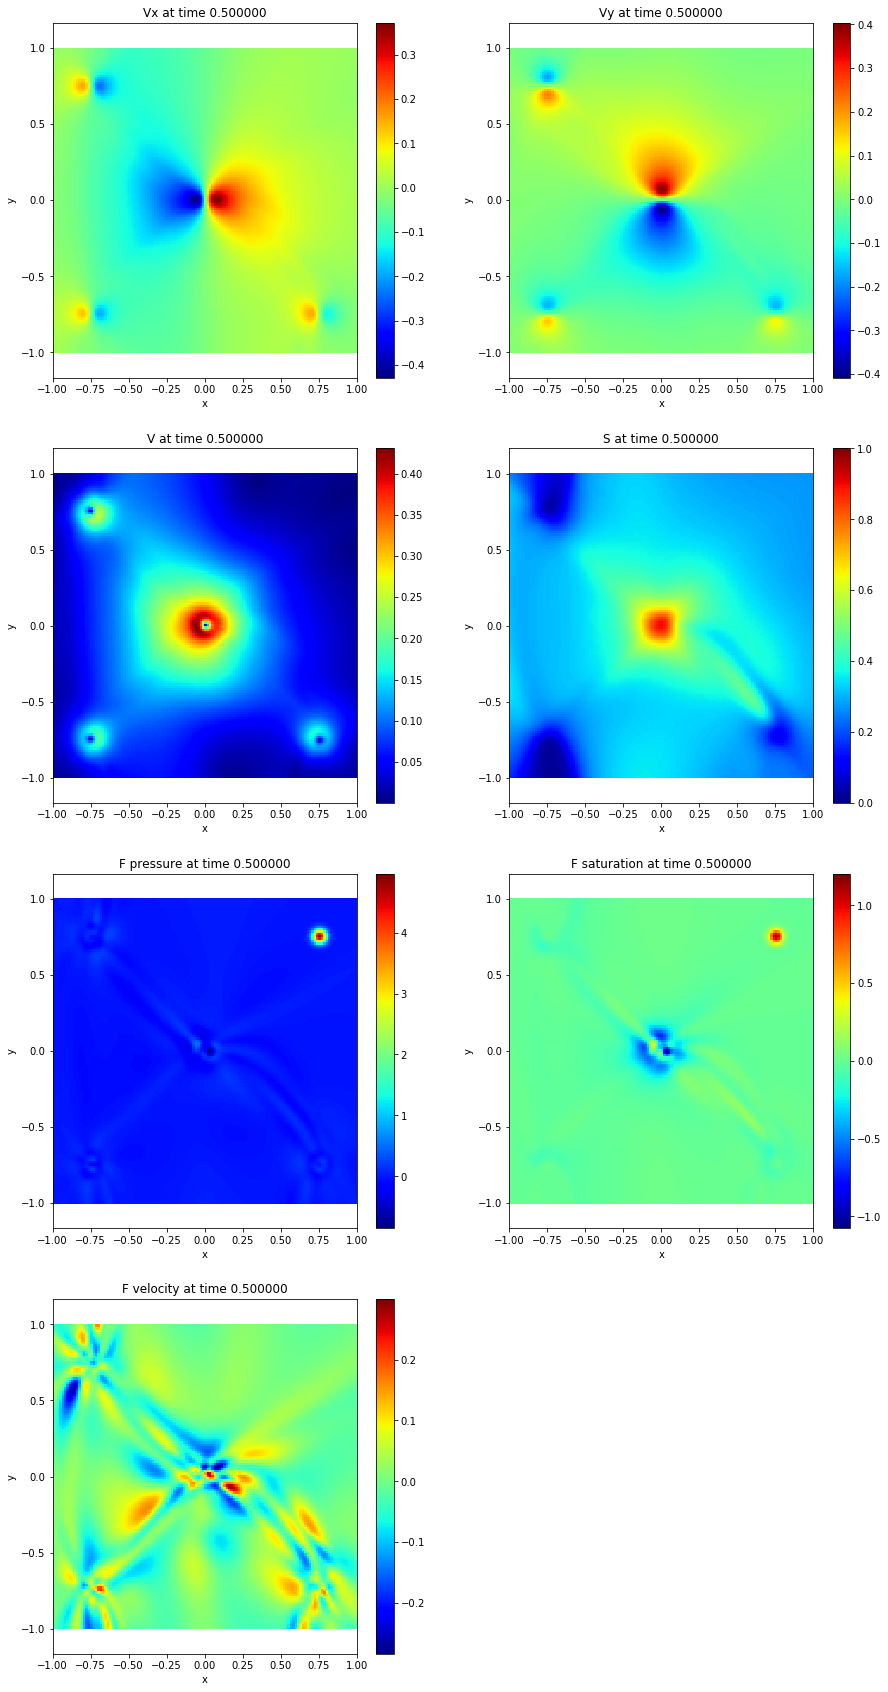

It: 0, Loss: 2.992e-02, Time: 1.25
It: 10, Loss: 8.858e-02, Time: 12.77
It: 20, Loss: 4.825e-02, Time: 12.72
It: 30, Loss: 2.937e-02, Time: 12.66
It: 40, Loss: 2.683e-02, Time: 12.98
It: 50, Loss: 2.322e-02, Time: 13.05
It: 60, Loss: 2.198e-02, Time: 12.73
It: 70, Loss: 2.213e-02, Time: 13.20
It: 80, Loss: 2.193e-02, Time: 13.95
It: 90, Loss: 2.185e-02, Time: 12.81
It: 100, Loss: 2.183e-02, Time: 13.15
It: 110, Loss: 2.180e-02, Time: 12.97
It: 120, Loss: 2.178e-02, Time: 12.80
It: 130, Loss: 2.176e-02, Time: 12.62
It: 140, Loss: 2.174e-02, Time: 12.78
It: 150, Loss: 2.173e-02, Time: 13.03
It: 160, Loss: 2.171e-02, Time: 13.17
It: 170, Loss: 2.170e-02, Time: 12.76
It: 180, Loss: 2.168e-02, Time: 13.02
It: 190, Loss: 2.167e-02, Time: 13.33
Iter: 00100, Loss: 2.01e-02, s: 5.631e-03, vx: 1.387e-04, vy: 1.169e-04, fp: 9.337e-03, fs: 3.427e-03, fv: 1.428e-03
Iter: 00200, Loss: 1.85e-02, s: 4.855e-03, vx: 1.493e-04, vy: 1.136e-04, fp: 9.069e-03, fs: 2.963e-03, fv: 1.371e-03
Iter: 00300, Loss:

KeyboardInterrupt: 

In [12]:
for i in range(10):
    start_time = time.time()
    if i<3:
        model.train(200)
    else:
        model.train(10)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    draw_prediction(0.5)

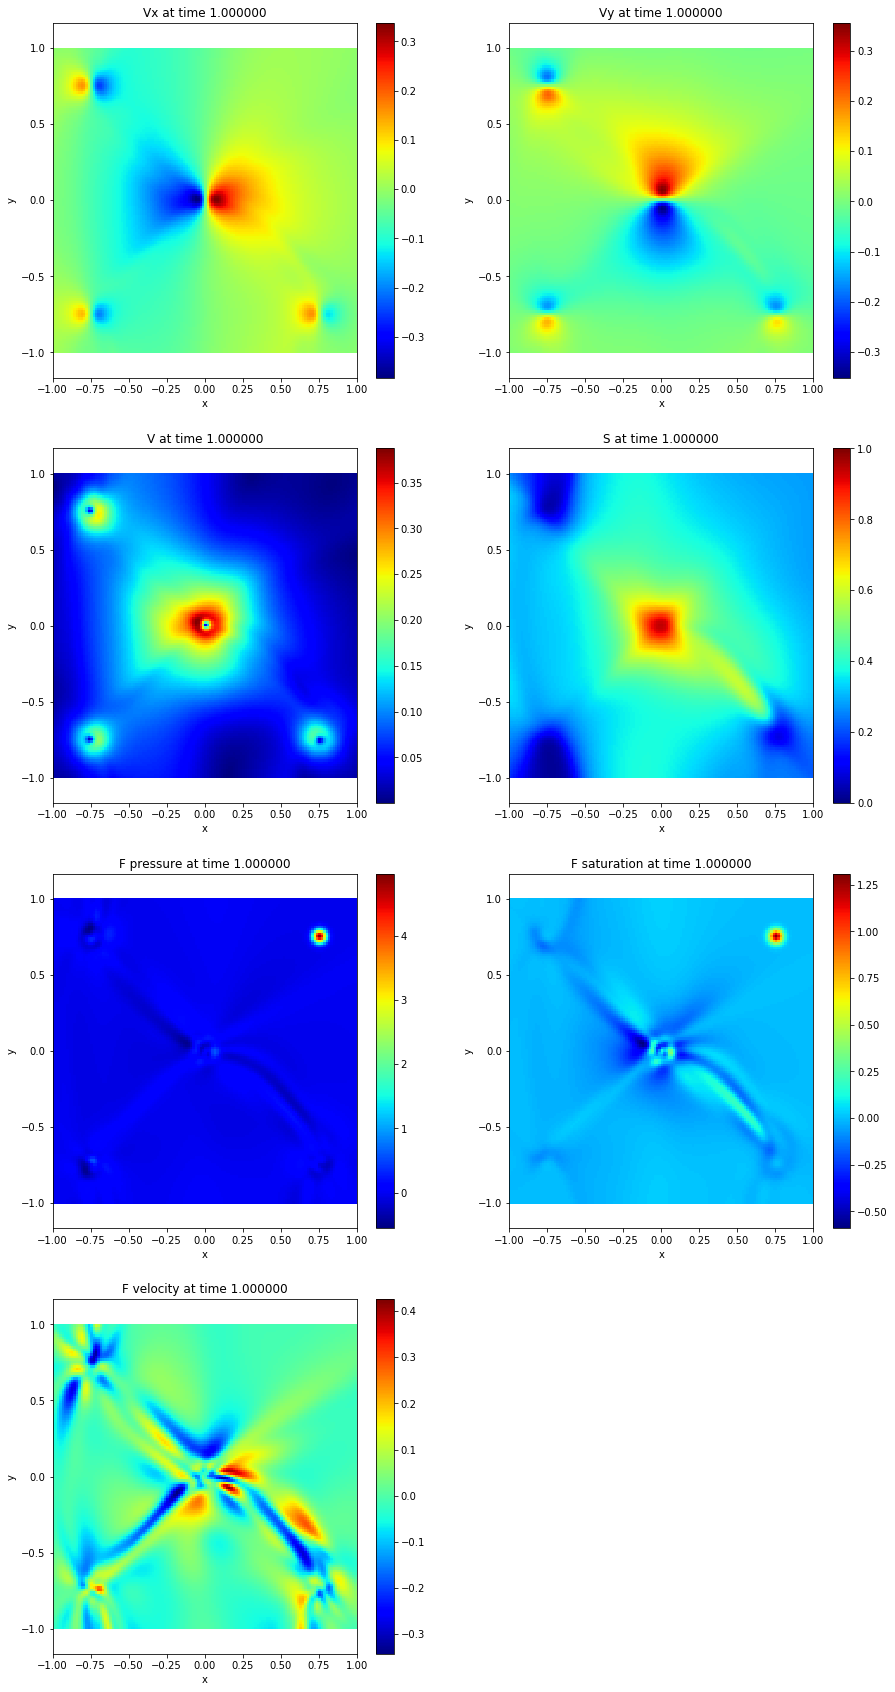

In [13]:
draw_prediction(1)